In [1]:
from load import StableDiffusionDetectionDataset
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from util import tfft, tabs, tlog, tnorm

In [2]:
batch_size = 16

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256)), transforms.RandomHorizontalFlip()])

# transform = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.Resize((256, 256)),
#         transforms.Lambda(tfft),
#         transforms.Lambda(tabs),
#         transforms.Lambda(tlog),
#         transforms.Lambda(tnorm),
#     ]
# )

dataset = StableDiffusionDetectionDataset('data/stable_diffusion_detection.csv', 'data', transform=transform, samples=4500)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)


/opt/homebrew/Caskroom/miniforge/base/envs/sdd/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


data[0].shape torch.Size([16, 3, 256, 256])
data[1].shape torch.Size([16, 1])
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])


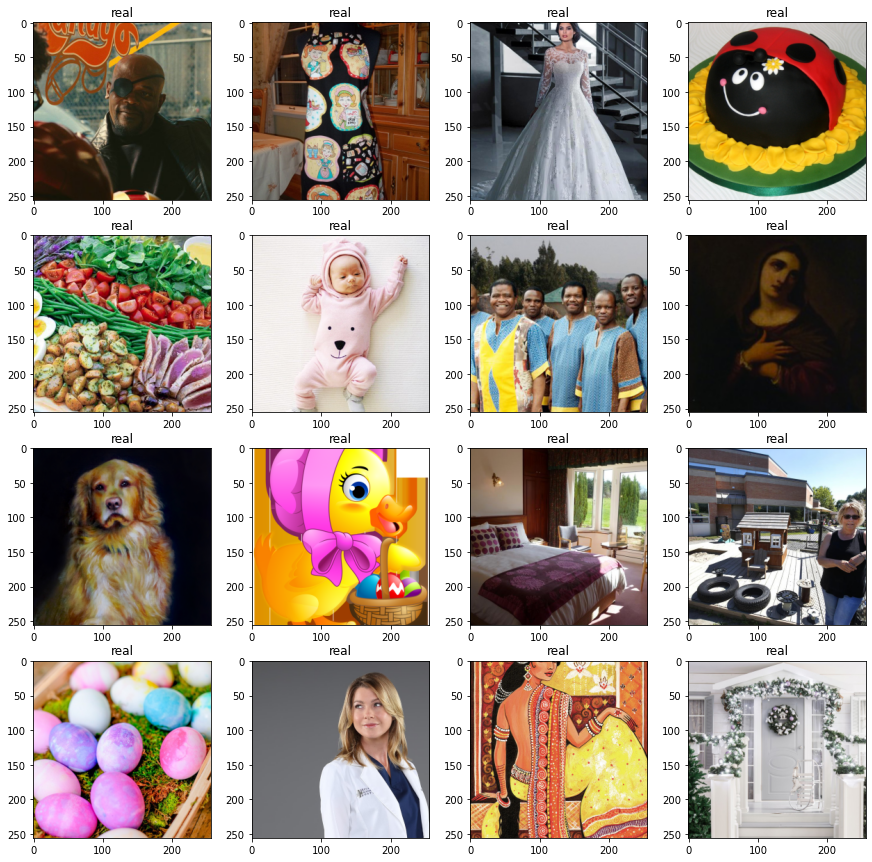

In [4]:
labels = ['fake', 'real']

for i, data in enumerate(iter(test_loader)):
    print('data[0].shape', data[0].shape)
    print('data[1].shape', data[1].shape)

    print(data[1])

    # Grid of 16 images, 4 rows x 4 columns
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))

    for j in range(16):
        # Get the image and label
        img = data[0][j]
        label = data[1][j][0]

        # Insert the image into the grid
        axs[j // 4, j % 4].imshow(img.permute(1, 2, 0))
        axs[j // 4, j % 4].set_title(labels[label.item()])


    break


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")


class VisionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding = 0):
        super(VisionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels - in_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels - in_channels)

        self.conv2 = nn.Conv2d(out_channels - in_channels, out_channels - in_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels - in_channels)


    def forward(self, img):
        img_ = self.conv1(img)
        img_ = self.bn1(img_)
        img_ = F.relu(img_)
        img_ = self.conv2(img_)
        img_ = self.bn2(img_)
        img_ = F.relu(img_)

        return torch.cat((img, img_), 1)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = VisionBlock(3, 16, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = VisionBlock(16, 32, 5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = VisionBlock(32, 64, 5, padding=2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = VisionBlock(64, 128, 5, padding=2)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)


    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))

        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x

model = Model()
model.to(device)

Model(
  (conv1): VisionBlock(
    (conv1): Conv2d(3, 13, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn1): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(13, 13, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn2): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): VisionBlock(
    (conv1): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): VisionBlock(
    (conv1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1),

In [14]:
learning_rate = 0.001
epochs = 2
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
## compute accuracy single output
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.round(logit).view(-1) == target.view(-1)).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy

In [15]:
for epoch in range(epochs):
  #Put the model in training mode
  model = model.train()

  train_running_loss = 0.0
  train_acc = 0.0
  for idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(torch.float32).to(device)

    ## forward + backprop + loss
    logits = model(images)
    loss = criterion(logits, labels)
    optimizer.zero_grad()
    loss.backward()

    ## update model params
    optimizer.step()
    
    train_running_loss += loss.detach().item()
    train_acc += get_accuracy(logits, labels, batch_size)

  print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / idx, train_acc / idx))

  

  model = model.eval()
  test_acc = 0.0
  for i, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      test_acc += get_accuracy(outputs, labels, batch_size)

  print(f"Test Accuracy: {test_acc/i}, in epoch: {epoch}")


Epoch: 0 | Loss: 0.1501 | Train Accuracy: 94.24
Test Accuracy: 92.01948547363281, in epoch: 0
Epoch: 1 | Loss: 0.1475 | Train Accuracy: 94.16
Test Accuracy: 92.84274291992188, in epoch: 1


In [16]:
model = model.eval()
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, batch_size)

print(f"Test Accuracy: {test_acc/i}, in epoch: {epoch}")

Test Accuracy: 92.69153594970703, in epoch: 1


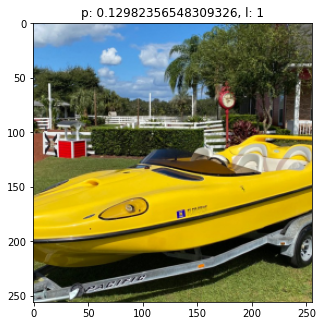

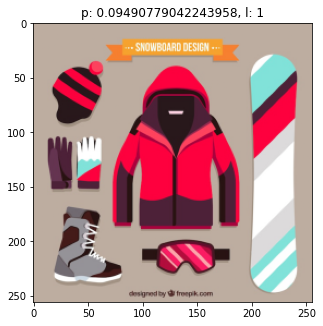

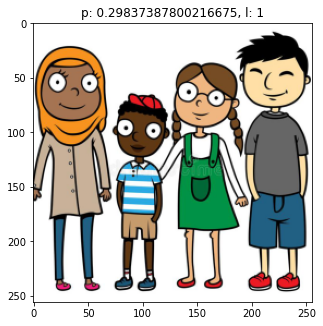

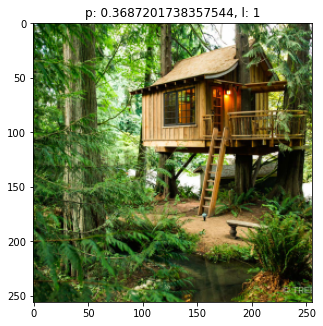

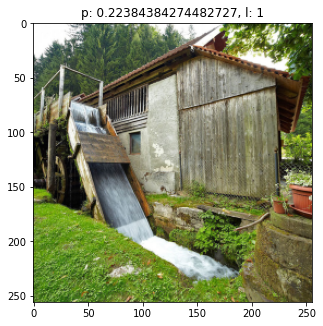

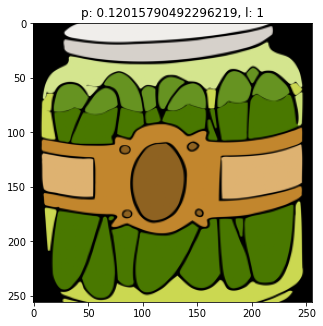

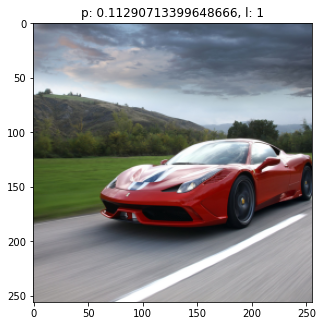

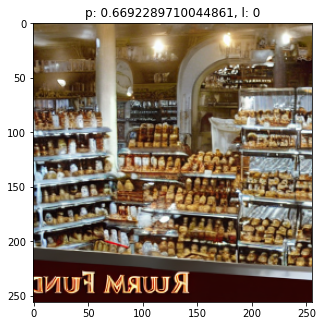

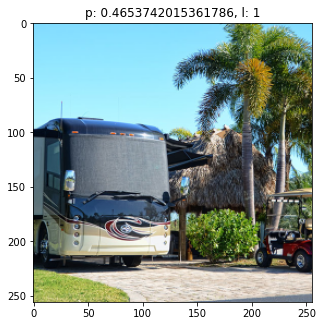

In [18]:
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)


    bad_images = []
    bad_preds = []
    bad_labels = []
    indices = (((torch.round(outputs).view(-1) == labels.view(-1)) == False).nonzero().view(-1))
    for index in indices:
        bad_images.append(images[index])
        bad_preds.append(outputs[index])
        bad_labels.append(labels[index])

    if len(bad_images) <= 0:
        continue

    for j in range(len(bad_images)):
        fig, ax = plt.subplots(figsize=(5, 10))
        ax.imshow(bad_images[j].cpu().permute(1, 2, 0))
        ax.set_title(f"p: {bad_preds[j].item()}, l: {bad_labels[j].item()}")
        plt.show()
    
    if i == 10:
        break
